In [ ]:
# mount Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
!pip install TensorFlow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm



In [ ]:
df = pd.read_csv('GOOG-year.csv')
df.head()

minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

#LSTM

In [ ]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
142/142 [==============================] - 17s 76ms/step - loss: 0.0198
Epoch 2/3
142/142 [==============================] - 11s 77ms/step - loss: 0.0074
Epoch 3/3
142/142 [==============================] - 5s 36ms/step - loss: 0.0058


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2/2 [==============================] - 1s 26ms/step


6.590858184609376

<ipython-input-9-d2f3bab62505>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


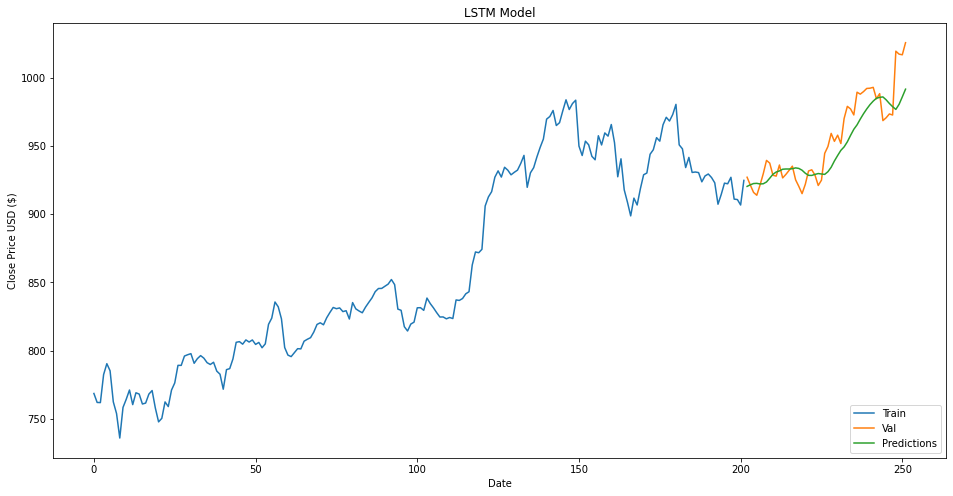

In [ ]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [ ]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

print('The Accuracy of LSTM model is : ' , calculate_accuracy(validation,predictions),'%')

The Accuracy of LSTM model is :  98.88363752274701 %


In [ ]:
#Reference:
#https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

#GRU

In [ ]:
model = keras.Sequential()
model.add(layers.GRU(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.GRU(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 100)           30900     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 94,051
Trainable params: 94,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
142/142 [==============================] - 8s 35ms/step - loss: 0.0091
Epoch 2/3
142/142 [==============================] - 5s 34ms/step - loss: 0.0038
Epoch 3/3
142/142 [==============================] - 5s 34ms/step - loss: 0.0027


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2/2 [==============================] - 1s 26ms/step


21.574887725625

<ipython-input-15-58a50f0ee237>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


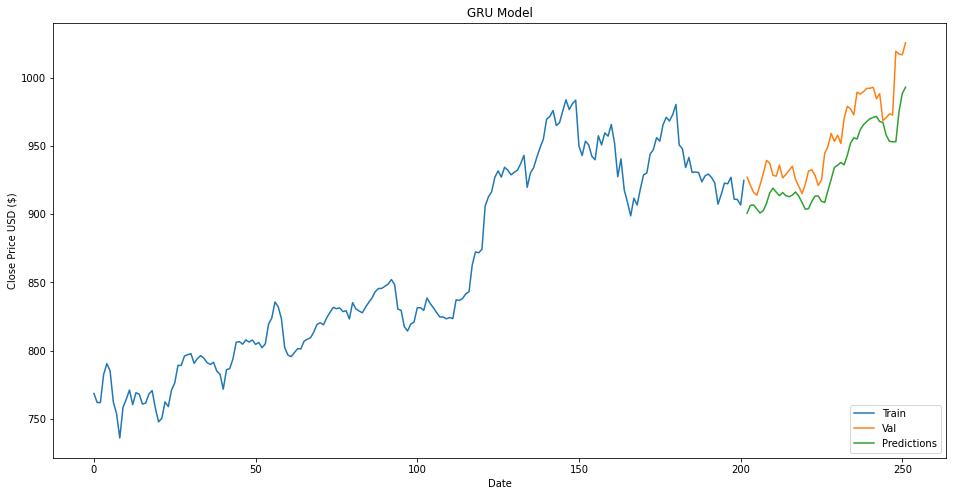

In [ ]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('GRU Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

print('The Accuracy of GRU model is : ' , calculate_accuracy(validation,predictions),'%')

The Accuracy of GRU model is :  98.23940419031531 %


#LSTM Bidirectional

In [ ]:

model_bi = tf.keras.Sequential()
model_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,input_shape=(x_train.shape[1], x_train.shape[2]))))
model_bi.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))


In [ ]:
model_bi.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['acc'])
model_bi.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
142/142 [==============================] - 8s 28ms/step - loss: 0.0244 - acc: 0.0000e+00
Epoch 2/3
142/142 [==============================] - 4s 27ms/step - loss: 0.0093 - acc: 0.0000e+00
Epoch 3/3
142/142 [==============================] - 4s 28ms/step - loss: 0.0068 - acc: 0.0000e+00


In [ ]:
model_bi.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (1, 200)                 81600     
 l)                                                              
                                                                 
 dense_4 (Dense)             (1, 1)                    201       
                                                                 
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_bi = model_bi.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/10
4/4 [==============================] - 5s 563ms/step - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 86ms/step - loss: 0.0045 - acc: 0.0000e+00 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 87ms/step - loss: 0.0044 - acc: 0.0000e+00 - val_loss: 0.0058 - val_acc: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 88ms/step - loss: 0.0037 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 89ms/step - loss: 0.0038 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 90ms/step - loss: 0.0038 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 90ms/step - loss: 0.0037 - acc: 0.0000e+00 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 8/10
4/4 [========================

In [ ]:
predictions = model_bi.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2/2 [==============================] - 1s 20ms/step


12.944417754921872

<ipython-input-22-84ac39fad5d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


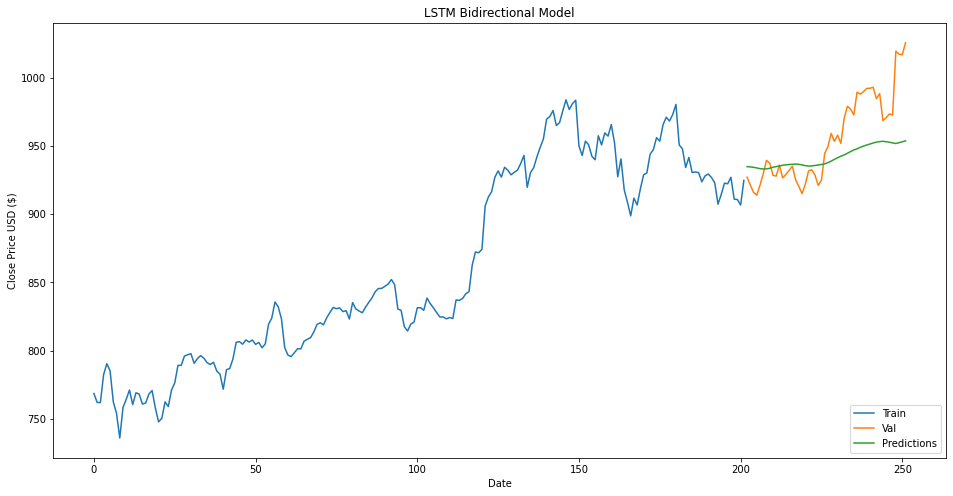

In [ ]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Bidirectional Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

print('The Accuracy of LSTM Bidirectional model is : ' , calculate_accuracy(validation,predictions),'%')

The Accuracy of LSTM Bidirectional model is :  98.01547316244745 %


#RNN

In [ ]:
model = keras.Sequential()
model.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.SimpleRNN(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 100)           10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 25)                2525      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32,851
Trainable params: 32,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
142/142 [==============================] - 4s 21ms/step - loss: 0.0836
Epoch 2/3
142/142 [==============================] - 3s 21ms/step - loss: 0.0052
Epoch 3/3
142/142 [==============================] - 3s 21ms/step - loss: 0.0061


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2/2 [==============================] - 0s 14ms/step


0.544217559609373

<ipython-input-27-ebffc65213c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


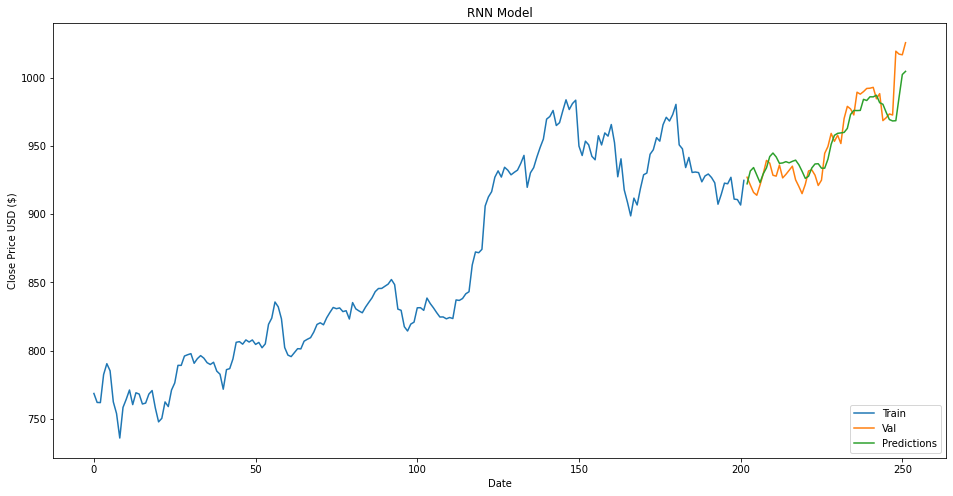

In [ ]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('RNN Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

print('The Accuracy of RNN model is : ' , calculate_accuracy(validation,predictions),'%')

The Accuracy of RNN model is :  99.06669902316389 %
